In [25]:
import numpy as np
from collections import Counter
from sklearn import datasets
from sklearn import model_selection
import random

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

1. Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50, 100, 200 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

In [2]:
random.seed(42)

In [3]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [4]:
class Node:
    def __init__(self, index, threshold, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.threshold = threshold  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        
class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        prediction = max(Counter(self.labels))
        return prediction
    
class Tree:
    def __init__(self, min_leaf=5, max_depth=3, max_features=None, criterion='gini'):
        self.root = None
        self.true_branch, self.false_branch = None, None
        
        self.min_leaf = min_leaf
        self.max_depth = max_depth
        self.max_features = max_features
        self.criterion = criterion
    
    def fit(self, data, labels):
        self.root = self._build(data, labels)
    
    def _build(self, data, labels):
        quality, threshold, index = self._find_best_split(data, labels)
        if quality == 0 or self.max_depth == 0:
            return Leaf(data, labels)

        true_data, false_data, true_labels, false_labels = self._split(data, labels, index, threshold)
        
        self.true_branch = Tree(min_leaf=self.min_leaf, max_depth=self.max_depth - 1)
        self.false_branch = Tree(min_leaf=self.min_leaf, max_depth=self.max_depth - 1)
        self.true_branch.fit(true_data, true_labels)
        self.false_branch.fit(false_data, false_labels)
        return Node(index, threshold, self.true_branch, self.false_branch)
    
    def _find_best_split(self, data, labels):
        current_criterion = 0
        criterion_func = None
        
        if self.criterion == 'gini':
            criterion_func = self._gini
        elif self.criterion == 'entropy':
            criterion_func = self._entropy
        else:
            raise Exception(f'Criterion {self.criterion} not defined')
        
        current_criterion = criterion_func(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]
        feature_indexes = [i for i in range(n_features)]
        if self.max_features and self.max_features < n_features:
            feature_indexes = np.random.choice(n_features, self.max_features, replace=False)
        
        for index in feature_indexes:
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])
            for t in t_values:
                
                true_data, false_data, true_labels, false_labels = self._split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < self.min_leaf or len(false_data) < self.min_leaf:
                    continue

                current_quality = self._quality(true_labels, false_labels, current_criterion, criterion_func)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index
    
    def _split(self, data, labels, index, t):
        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels
    
    def _gini(self, labels):
        classes = Counter(labels)
        impurity = 1
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p ** 2
        return impurity

    def _entropy(self, labels):
        classes = Counter(labels)
        impurity = 0
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p * np.log2(p)
        return impurity
    
    def _quality(self, left_labels, right_labels, current_criterion, criterion_func):
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
        return current_criterion - p * criterion_func(left_labels) - (1 - p) * criterion_func(right_labels)


    def classify_object(self, obj):
        if isinstance(self.root, Leaf):
            return self.root.prediction
        
        if obj[self.root.index] <= self.root.threshold:
            return self.true_branch.classify_object(obj)
        else:
            return self.false_branch.classify_object(obj)
    
    def predict(self, data):
        return [self.classify_object(obj) for obj in data]

    # Напечатаем ход нашего дерева
    def __str__(self, spacing=""):
        output = []
        if isinstance(self.root, Leaf):
            output.append(spacing + f'Прогноз: {self.root.prediction}')
        else:
            output.append(spacing + f'Индекс {self.root.index}')
            output.append(spacing + f'Порог {self.root.threshold}')

            output.append(spacing + '--> True:')
            output.append(spacing + self.true_branch.__str__(spacing='  '))

            output.append(spacing + '--> False:')
            output.append(spacing + self.false_branch.__str__(spacing='  '))
        return '\n'.join(output)


In [5]:
class RandomForest:
    def __init__(self, n_trees, sample_size=None, min_leaf=1, max_depth=100, max_features=None, criterion='gini', use_subsample=False):
        self.n_trees = n_trees
        self.sample_size = sample_size
        self.data_size = None
        
        self.min_leaf = min_leaf
        self.max_depth = max_depth
        self.max_features = max_features
        self.criterion = criterion
        self.use_subsample = use_subsample
        
        self.forest = []
        
    def _get_bootstrap(self, data, labels):
        bootstrap = []

        for _ in range(self.n_trees):
            random_indexes = np.random.choice(self.data_size, size=self.data_size)
            bootstrap.append((classification_data[random_indexes], classification_labels[random_indexes]))

        return bootstrap

    def _get_subsample(self, len_sample):
        return np.random.choice(len_sample, size=int(np.sqrt(len_sample)), replace=False)

    def fit(self, data, labels):
        self.data_size = data.shape[0]
        if not self.sample_size:
            self.sample_size = data.shape[1]
        
        bootstrap = self._get_bootstrap(data, labels)
        for b_data, b_labels in bootstrap:
            tree = Tree(min_leaf=self.min_leaf, 
                        max_depth=self.max_depth, 
                        max_features=self.max_features, 
                        criterion=self.criterion)
            if self.use_subsample:
                subsample_indexes = self._get_subsample(self.sample_size)
                tree.fit(b_data[:, subsample_indexes], b_labels)
            else:
                tree.fit(b_data, b_labels)
            self.forest.append(tree)

    def predict(self, data):

        # добавим предсказания всех деревьев в список
        predictions = []
        for tree in self.forest:
            predictions.append(tree.predict(data))

        # сформируем список с предсказаниями для каждого объекта
        predictions_per_object = list(zip(*predictions))

        # выберем в качестве итогового предсказания для каждого объекта то,
        # за которое проголосовало большинство деревьев
        voted_predictions = []
        for obj in predictions_per_object:
            voted_predictions.append(max(set(obj), key=obj.count))

        return voted_predictions

In [6]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

def plot_results(my_tree, train_data,test_data, train_accuracy, test_accuracy):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(my_tree.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

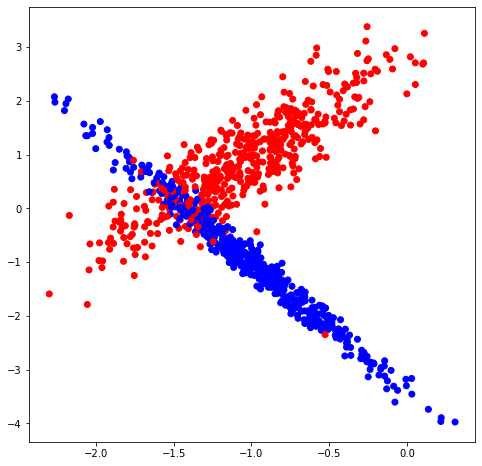

In [7]:
classification_data, classification_labels = datasets.make_classification(n_samples=1000,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [8]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3)

In [9]:
def run(n_trees, use_subsample=False):
    my_forest = RandomForest(n_trees=n_trees, min_leaf=5, max_depth=40, max_features=5, use_subsample=use_subsample)
    my_forest.fit(train_data, train_labels)
    train_answers = my_forest.predict(train_data)
    test_answers = my_forest.predict(test_data)
    train_accuracy = accuracy_metric(train_labels, train_answers)
    test_accuracy = accuracy_metric(train_labels, train_answers)

    plot_results(my_forest, train_data,test_data, train_accuracy, test_accuracy)

<ipython-input-6-53f71c533bad>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-6-53f71c533bad>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


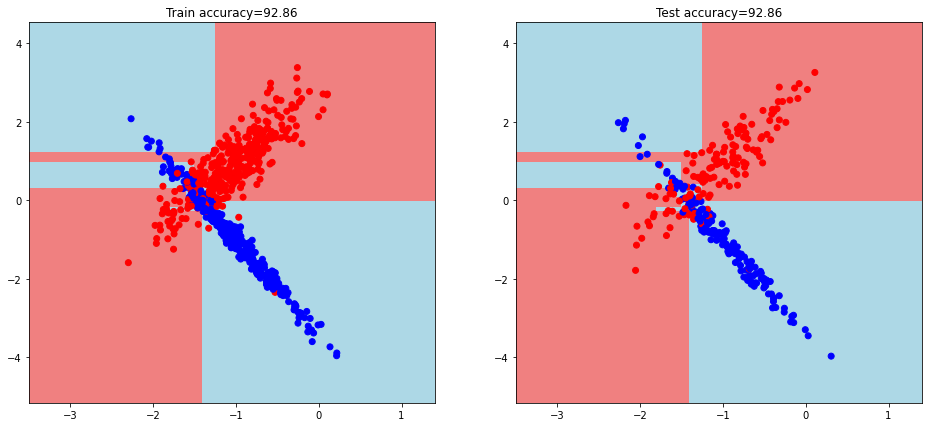

In [10]:
run(1)

<ipython-input-6-53f71c533bad>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-6-53f71c533bad>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


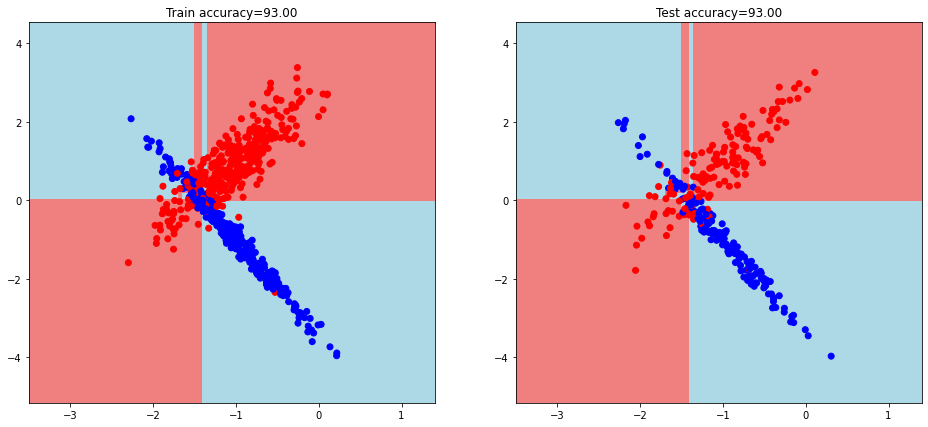

In [11]:
run(3)

<ipython-input-6-53f71c533bad>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-6-53f71c533bad>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


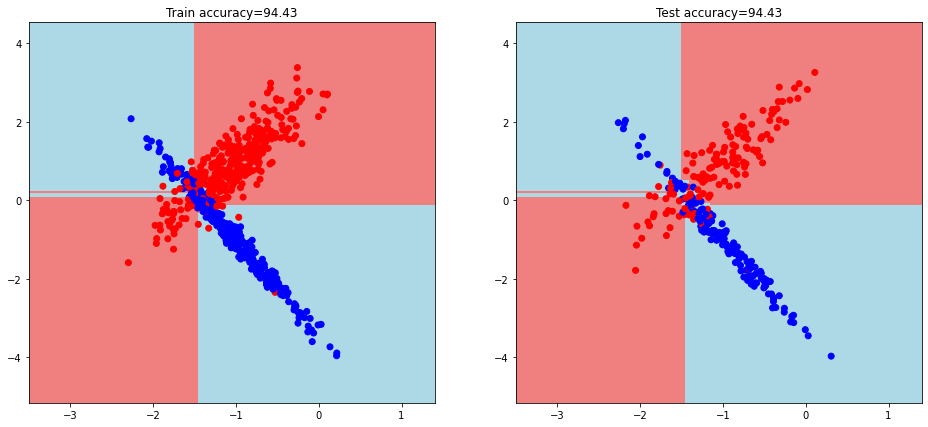

In [12]:
run(10)

<ipython-input-6-53f71c533bad>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-6-53f71c533bad>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


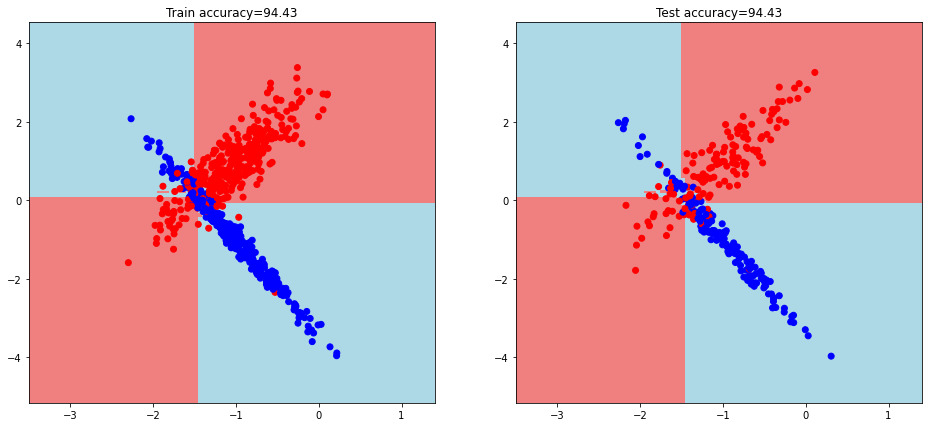

In [13]:
run(50)

<ipython-input-6-53f71c533bad>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-6-53f71c533bad>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


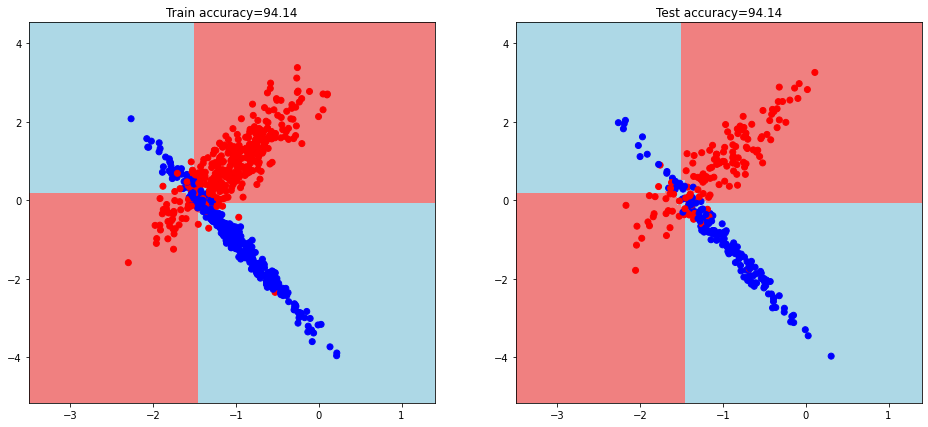

In [14]:
run(100)

<ipython-input-6-53f71c533bad>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-6-53f71c533bad>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


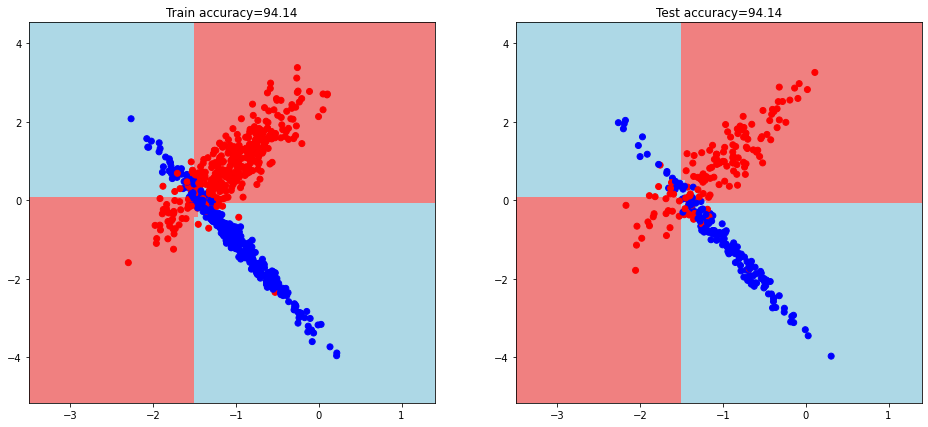

In [15]:
run(200)

При параметрах в реализованных экспериментах явное переобучение не наблюдается, сложность гиперплоскости возрастает с увеличением количества деревьев, наилучшее качество модели получено при 10-50 деревьях